In [11]:
import os
import shutil
import stat

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Copy the kaggle.json file to the .kaggle directory
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# Change the permissions of the kaggle.json file
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), stat.S_IRUSR | stat.S_IWUSR)

In [10]:
!kaggle competitions download -c isic-2024-challenge

^C



  0%|          | 0.00/2.00G [00:00<?, ?B/s]
  0%|          | 1.00M/2.00G [00:01<46:04, 777kB/s]
  0%|          | 2.00M/2.00G [00:01<22:57, 1.56MB/s]
  0%|          | 3.00M/2.00G [00:01<14:23, 2.49MB/s]
  0%|          | 4.00M/2.00G [00:01<10:08, 3.52MB/s]
  0%|          | 5.00M/2.00G [00:02<09:54, 3.60MB/s]
  0%|          | 6.00M/2.00G [00:02<07:53, 4.53MB/s]
  0%|          | 8.00M/2.00G [00:02<05:37, 6.33MB/s]
  0%|          | 9.00M/2.00G [00:02<05:28, 6.51MB/s]
  0%|          | 10.0M/2.00G [00:02<05:34, 6.39MB/s]
  1%|          | 11.0M/2.00G [00:02<05:29, 6.48MB/s]
  1%|          | 12.0M/2.00G [00:02<05:12, 6.84MB/s]
  1%|          | 13.0M/2.00G [00:03<04:59, 7.13MB/s]
  1%|          | 14.0M/2.00G [00:03<04:57, 7.17MB/s]
  1%|          | 15.0M/2.00G [00:03<04:52, 7.28MB/s]
  1%|          | 16.0M/2.00G [00:03<04:51, 7.31MB/s]
  1%|          | 17.0M/2.00G [00:03<04:52, 7.29MB/s]
  1%|          | 18.0M/2.00G [00:03<05:00, 7.09MB/s]
  1%|          | 19.0M/2.00G [00:03<04:48, 7.37MB/s]
  

## Import Necessary Libraries 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # other options: tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf
import cv2

import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 

In [2]:
tf.__version__
keras_cv.__version__

'0.9.0'

## Configration 

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    neg_sample = 0.01 # Downsample negative calss
    pos_sample = 5.0  # Upsample positive class
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [128, 128]  # Input image size
    epochs = 8 # Training epochs
    batch_size = 256  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    class_names = ['target']
    num_classes = 1

In [4]:
keras.utils.set_random_seed(CFG.seed)

## Dataset 

In [5]:
train=pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
train.ffill()
train.sample(5)



<ipython-input-5-2c3cdcacb3a4>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train=pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-pa

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
278442,ISIC_6973879,0,IP_3201881,55.0,female,lower extremity,3.15,TBP tile: close-up,3D: XP,15.998595,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.00000
215021,ISIC_5407194,0,IP_5714646,40.0,male,posterior torso,3.03,TBP tile: close-up,3D: XP,17.651690,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.99993
209685,ISIC_5273739,0,IP_6391213,85.0,male,lower extremity,2.72,TBP tile: close-up,3D: XP,11.409180,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,95.00602
29648,ISIC_0802250,0,IP_6611217,55.0,male,posterior torso,3.58,TBP tile: close-up,3D: XP,15.982470,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.98764
323386,ISIC_8084953,0,IP_6957489,70.0,male,posterior torso,5.52,TBP tile: close-up,3D: XP,13.933450,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.76251


In [6]:
test=pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
test.ffill()


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


-- Test data is two less . We have to create test data from training Image.

## Handleing Imbalenced Dataset

In [7]:
train.target.value_counts()

target
0    400666
1       393
Name: count, dtype: int64

#### Sample Parameter
- DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None, ignore_index=False)

In [8]:
negative_df=train[train["target"]== 0].sample(frac=CFG.neg_sample,random_state=CFG.seed)
positive_df=train[train["target"]== 1].sample(frac=CFG.pos_sample,random_state=CFG.seed,replace=True)
df=pd.concat([negative_df,positive_df])
df.target.value_counts()

target
0    4007
1    1965
Name: count, dtype: int64

## Load Images By useing H5py file

In [9]:
import h5py

train_h5py=h5py.File("/kaggle/input/isic-2024-challenge/train-image.hdf5","r")
testing_hdf5 = h5py.File("/kaggle/input/isic-2024-challenge/test-image.hdf5","r")

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


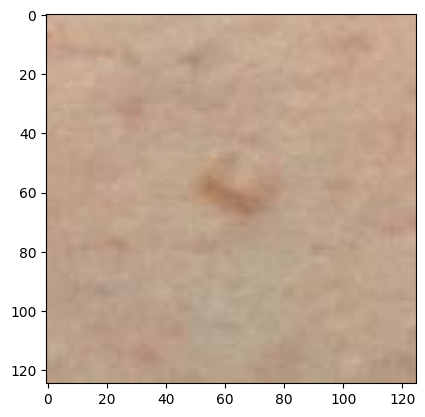

In [10]:
isic_id = test.isic_id.iloc[1]

# Image as Byte String
byte_string = testing_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)

print("Image:")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image);

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


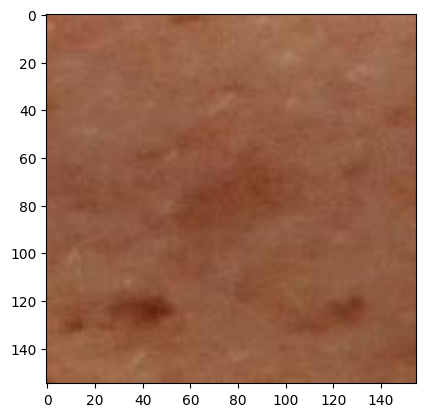

In [11]:
isic_id = df.isic_id.iloc[7]

# Image as Byte String
byte_string = train_h5py[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)

print("Image:")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image);

## Meta data + Image Data

In [12]:
def Image_nparray(id1):
    byte_string = train_h5py[id1][()]
    nparr = np.frombuffer(byte_string, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    image_resized = cv2.resize(image, (128, 128))
    image_vector = image_resized.astype(np.float32) / 255.0
    return image_vector


images = []

for i in range(len(df)):
    isic_id = df.isic_id.iloc[i]  # Use the current index
    image_array = Image_nparray(isic_id)
    images.append(image_array)
df["image"] = images

In [13]:
# Categorical features which will be one hot encoded
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]
Primary_key=["isic_id","image","target"]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

FEAT_COLS = Primary_key + CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
FEAT_COLS

['isic_id',
 'image',
 'target',
 'sex',
 'anatom_site_general',
 'tbp_tile_type',
 'tbp_lv_location',
 'age_approx',
 'tbp_lv_nevi_confidence',
 'clin_size_long_diam_mm',
 'tbp_lv_areaMM2',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_color_std_mean',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_minorAxisMM']

In [14]:
df=df[FEAT_COLS]

In [15]:
df["target"].value_counts()

target
0    4007
1    1965
Name: count, dtype: int64

In [16]:
df["image"].iloc[0].shape

(128, 128, 3)

## Class Distribution

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5972 entries, 366867 to 206980
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   isic_id                  5972 non-null   object 
 1   image                    5972 non-null   object 
 2   target                   5972 non-null   int64  
 3   sex                      5800 non-null   object 
 4   anatom_site_general      5918 non-null   object 
 5   tbp_tile_type            5972 non-null   object 
 6   tbp_lv_location          5972 non-null   object 
 7   age_approx               5925 non-null   float64
 8   tbp_lv_nevi_confidence   5972 non-null   float64
 9   clin_size_long_diam_mm   5972 non-null   float64
 10  tbp_lv_areaMM2           5972 non-null   float64
 11  tbp_lv_area_perim_ratio  5972 non-null   float64
 12  tbp_lv_color_std_mean    5972 non-null   float64
 13  tbp_lv_deltaLBnorm       5972 non-null   float64
 14  tbp_lv_minorAxisMM    

In [18]:
df=df.dropna()

## Encodeing Categorical Column

In [19]:
df=df.drop(columns=["isic_id"])

In [20]:
from sklearn.preprocessing import LabelEncoder
# Identify object columns
object_columns = df.select_dtypes(include=['object']).columns

# Create a LabelEncoder instance
labelencoder = LabelEncoder()

# Encode object columns
for column in object_columns:
    if column!= "image":
        df[column] = labelencoder.fit_transform(df[column])
df

,image,target,sex,anatom_site_general,tbp_tile_type,tbp_lv_location,age_approx,tbp_lv_nevi_confidence,clin_size_long_diam_mm,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM
366867,"[[[0.37254903, 0.5137255, 0.7490196], [0.35294...",0,1,4,0,8,60.0,4.638791e-02,2.60,2.852318,18.558940,0.081172,5.718410,1.506849
3463,"[[[0.21568628, 0.35686275, 0.5058824], [0.2235...",0,0,4,0,9,55.0,1.358552e-06,3.30,4.728842,19.874324,0.461697,5.530585,2.056787
251028,"[[[0.23921569, 0.3647059, 0.62352943], [0.2862...",0,1,3,0,15,65.0,1.338449e+01,6.05,9.495215,34.247010,0.799688,7.423611,2.742270
92251,"[[[0.41568628, 0.56078434, 0.70980394], [0.419...",0,1,0,0,16,85.0,7.583112e+01,2.52,3.115031,13.763510,0.652644,8.513734,1.549823
60498,"[[[0.3372549, 0.42745098, 0.5294118], [0.34901...",0,1,0,0,17,65.0,7.294813e-13,3.10,6.699193,14.262140,1.069682,15.183700,2.712190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81522,"[[[0.43529412, 0.49803922, 0.6666667], [0.4431...",1,1,1,1,0,80.0,1.431412e-29,4.68,6.398949,29.315400,1.450192,7.342936,2.110608
90669,"[[[0.5764706, 0.6313726, 0.8352941], [0.572549...",1,1,1,1,0,65.0,1.029675e+00,2.95,5.892287,15.318991,2.732248,7.622815,2.485120
155136,"[[[0.42745098, 0.5254902, 0.6509804], [0.43529...",1,0,2,0,4,60.0,6.294763e-04,9.96,60.780630,19.951150,3.529876,11.030040,7.682218
172939,"[[[0.59607846, 0.64705884, 0.7490196], [0.5803...",1,0,2,1,5,40.0,3.555990e+00,7.56,29.011071,17.526849,3.153132,8.993092,5.267661


## DataSet Split

In [21]:
# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess tabular data
tabular_columns = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'age_approx', 
                   'tbp_lv_nevi_confidence', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 
                   'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaLBnorm', 
                   'tbp_lv_minorAxisMM']

X_train_tabular = X_train[tabular_columns]
X_test_tabular = X_test[tabular_columns]

# Standardize the tabular data
scaler = StandardScaler()
X_train_tabular = scaler.fit_transform(X_train_tabular)
X_test_tabular = scaler.transform(X_test_tabular)

# # Preprocess image data
# 
X_train_images =np.stack(X_train['image'].apply(lambda x: np.array(x)/255))
# 
X_test_images = np.stack(X_test['image'].apply(lambda x: np.array(x)/255 ))

# # Resize images to 128x128x3
X_train_images = tf.image.resize(X_train_images, [128, 128])
X_test_images = tf.image.resize(X_test_images, [128, 128])

In [22]:
df["image"]

366867    [[[0.37254903, 0.5137255, 0.7490196], [0.35294...
3463      [[[0.21568628, 0.35686275, 0.5058824], [0.2235...
251028    [[[0.23921569, 0.3647059, 0.62352943], [0.2862...
92251     [[[0.41568628, 0.56078434, 0.70980394], [0.419...
60498     [[[0.3372549, 0.42745098, 0.5294118], [0.34901...
                                ...                        
81522     [[[0.43529412, 0.49803922, 0.6666667], [0.4431...
90669     [[[0.5764706, 0.6313726, 0.8352941], [0.572549...
155136    [[[0.42745098, 0.5254902, 0.6509804], [0.43529...
172939    [[[0.59607846, 0.64705884, 0.7490196], [0.5803...
206980    [[[0.38431373, 0.5294118, 0.6627451], [0.40392...
Name: image, Length: 5707, dtype: object

## Model Buidling

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform

### from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
Xavier (also known as Glorot) initialization is a weight initialization technique designed to enable activations and gradients to flow effectively during forward and backpropagation in neural networks2. It considers the number of input and output units of each layer to determine the scale of the random initialization

In [24]:
# Input layers
image_input = Input(shape=(128, 128, 3), name='image_input')
tabular_input = Input(shape=(X_train_tabular.shape[1],), name='tabular_input')

# CNN for image data
effnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
effnet.trainable = False  # Freeze the pre-trained layers
x = effnet(image_input)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# ANN for tabular data
y = Dense(128, activation='relu',kernel_initializer=GlorotNormal())(tabular_input)
y = Dropout(0.5)(y)
y=Dense(64,activation="relu",kernel_initializer=GlorotNormal())(y)
y = Dropout(0.3)(y)
y=Dense(32,activation="relu",kernel_initializer=GlorotNormal())(y)

# Concatenate both models
combined = Concatenate()([x, y])

# Final layers
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Create the model
model = Model(inputs=[image_input, tabular_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │          1,664 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 4, 4, 1280)     │      4,049,571 │ image_input[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 20480)          │              0 │ efficientnetb0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      2,621,568 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 160)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │         10,304 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,693,508 (25.53 MB)

 Trainable params: 2,643,937 (10.09 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
# Train the model
history = model.fit(
    [X_train_images, X_train_tabular], y_train,
    validation_data=([X_test_images, X_test_tabular], y_test),
    epochs=30,
    batch_size=16,
    callbacks=[callback]
)

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.6845 - loss: 0.9642 - val_accuracy: 0.8109 - val_loss: 0.4411
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8032 - loss: 0.4581 - val_accuracy: 0.8187 - val_loss: 0.4028
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8117 - loss: 0.4177 - val_accuracy: 0.8406 - val_loss: 0.3806
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8294 - loss: 0.3921 - val_accuracy: 0.8371 - val_loss: 0.3676
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8383 - loss: 0.3772 - val_accuracy: 0.8459 - val_loss: 0.3538
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8417 - loss: 0.3616 - val_accuracy: 0.8529 - val_loss: 0.3432
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8493 - loss: 0.3543 - val_accuracy: 0.8529 - val_loss: 0.3312
Epoch 8/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8622 - loss: 0.3237 - val_acc

In [26]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_images, X_test_tabular], y_test,batch_size=16)
print(f'Test Accuracy: {accuracy:.4f}')

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8696 - loss: 0.2594
Test Accuracy: 0.8765


In [27]:
# Save the model
model.save('skin_cancer_model1.h5')

In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already loaded your model, X_test_images, X_test_tabular, and y_test

# 1. Evaluate the model to get loss and accuracy
loss, accuracy = model.evaluate([X_test_images, X_test_tabular], y_test, verbose=0,batch_size=16)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 2. Get the model's predictions
y_pred_probs = model.predict([X_test_images, X_test_tabular])

# Convert probabilities to predicted labels (binary classification)
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5

# Handle the case where y_test might be one-hot encoded (unlikely in binary, but checking)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# 3. Calculate precision, recall, and F1 score (binary classification)
precision = precision_score(y_test_labels, y_pred)
recall = recall_score(y_test_labels, y_pred)
f1score = f1_score(y_test_labels, y_pred)

# 4. Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1score:.4f}')


Test Loss: 0.2599
Test Accuracy: 0.8765
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step
Precision: 0.7775
Recall: 0.8567
F1 Score: 0.8152


## Finetuneing

In [29]:
# Input layers
image_input = Input(shape=(128, 128, 3), name='image_input')
tabular_input = Input(shape=(X_train_tabular.shape[1],), name='tabular_input')

# CNN for image data
effnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
effnet.trainable = True
for layer in effnet.layers[:100]:
    layer.trainable = False
x = effnet(image_input)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# ANN for tabular data
y = Dense(256, activation='relu',kernel_initializer=GlorotNormal())(tabular_input)
y = Dropout(0.5)(y)
y = Dense(128, activation='relu',kernel_initializer=GlorotNormal())(tabular_input)
y = Dropout(0.5)(y)
y=Dense(64,activation="relu",kernel_initializer=GlorotNormal())(y)
y = Dropout(0.3)(y)
y=Dense(32,activation="relu",kernel_initializer=GlorotNormal())(y)

# Concatenate both models
combined = Concatenate()([x, y])

# Final layers
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Create the model
model = Model(inputs=[image_input, tabular_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │          1,664 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 4, 4, 1280)     │      4,049,571 │ image_input[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 20480)          │              0 │ efficientnetb0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │      2,621,568 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          2,080 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 160)            │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │         10,304 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 1)              │             65 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,693,508 (25.53 MB)

 Trainable params: 6,484,285 (24.74 MB)

 Non-trainable params: 209,223 (817.28 KB)

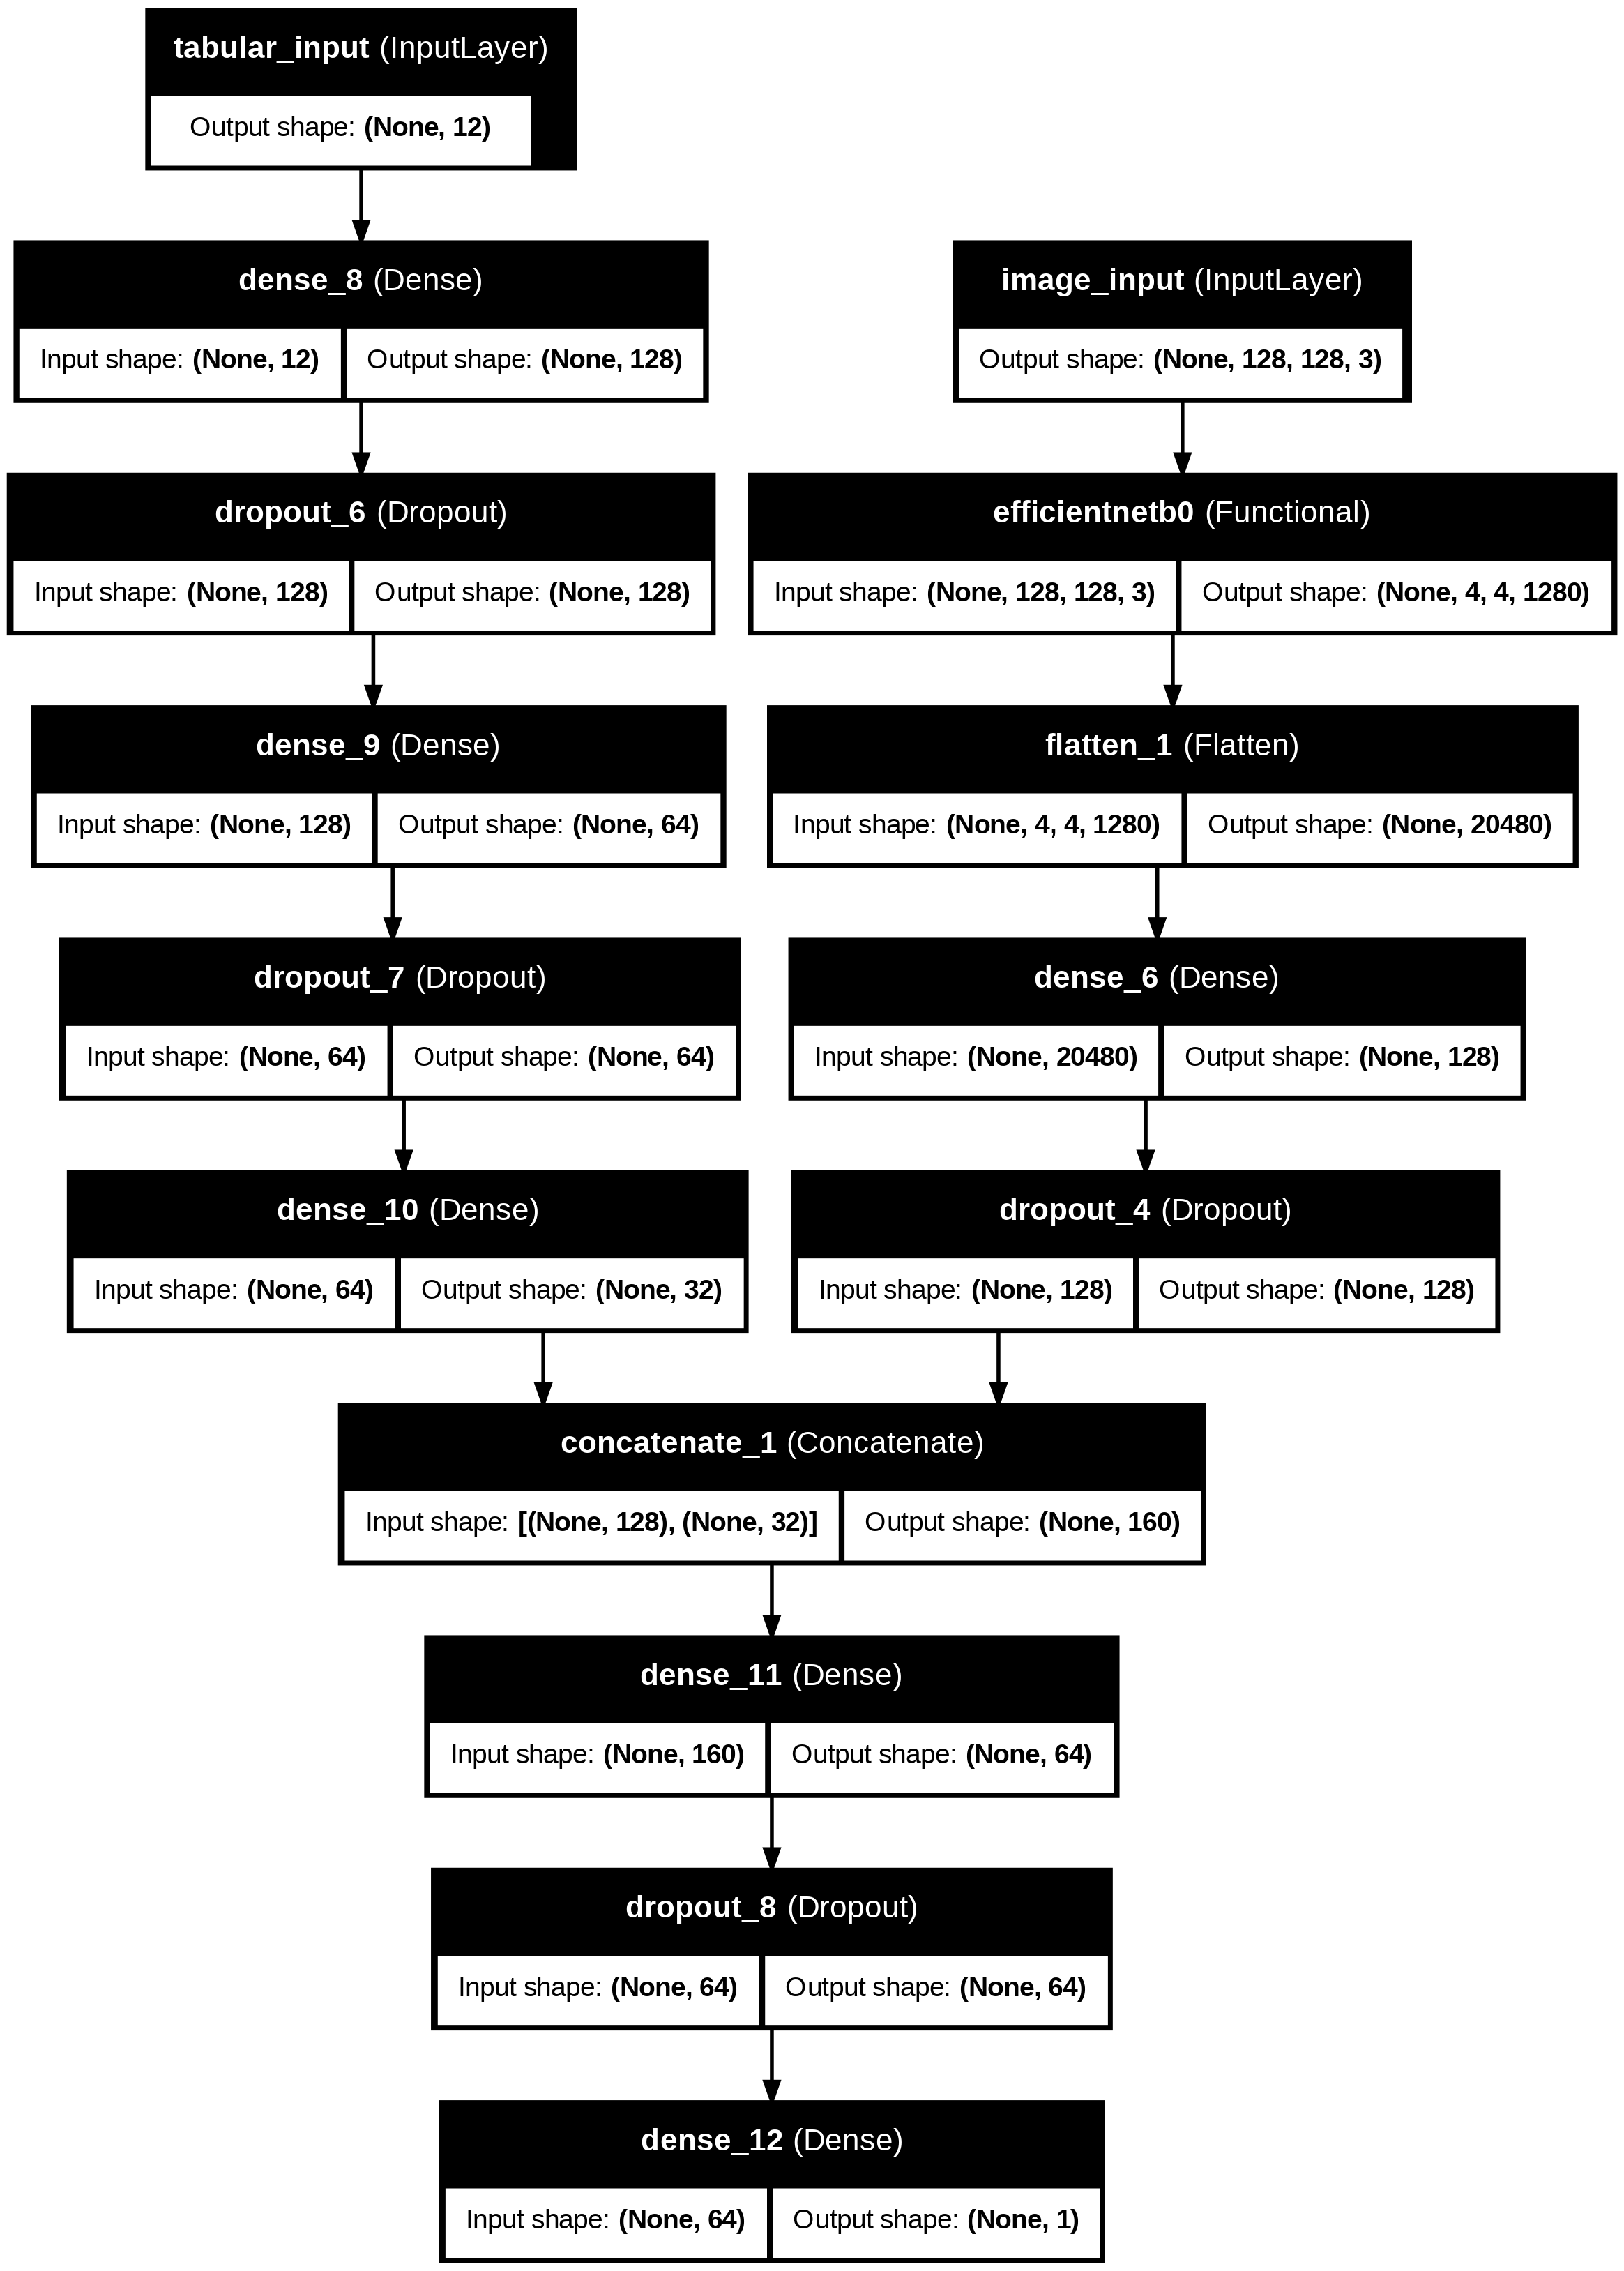

In [30]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [31]:
# Train the model
history = model.fit(
    [X_train_images, X_train_tabular], y_train,
    validation_data=([X_test_images, X_test_tabular], y_test),
    epochs=30,
    batch_size=16,
    callbacks=[callback]
)

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 126ms/step - accuracy: 0.6230 - loss: 1.0100 - val_accuracy: 0.8109 - val_loss: 0.4344
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8128 - loss: 0.4434 - val_accuracy: 0.8284 - val_loss: 0.3971
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8300 - loss: 0.4109 - val_accuracy: 0.8380 - val_loss: 0.3735
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8363 - loss: 0.3845 - val_accuracy: 0.8573 - val_loss: 0.3492
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8408 - loss: 0.3717 - val_accuracy: 0.8625 - val_loss: 0.3341
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8410 - loss: 0.3607 - val_accuracy: 0.8590 - val_loss: 0.3308
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8488 - loss: 0.3472 - val_accuracy: 0.8625 - val_loss: 0.3240
Epoch 8/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8579 - loss: 0.3415 - val_ac

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_images, X_test_tabular], y_test,batch_size=16)
print(f'Test Accuracy: {accuracy:.4f}')

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8773 - loss: 0.2696
Test Accuracy: 0.8827


In [33]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already loaded your model, X_test_images, X_test_tabular, and y_test

# 1. Evaluate the model to get loss and accuracy
loss, accuracy = model.evaluate([X_test_images, X_test_tabular], y_test, verbose=0,batch_size=16)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 2. Get the model's predictions
y_pred_probs = model.predict([X_test_images, X_test_tabular])

# Convert probabilities to predicted labels (binary classification)
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5

# Handle the case where y_test might be one-hot encoded (unlikely in binary, but checking)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# 3. Calculate precision, recall, and F1 score (binary classification)
precision = precision_score(y_test_labels, y_pred)
recall = recall_score(y_test_labels, y_pred)
f1score = f1_score(y_test_labels, y_pred)

# 4. Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1score:.4f}')


Test Loss: 0.2674
Test Accuracy: 0.8827
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step
Precision: 0.7827
Recall: 0.8733
F1 Score: 0.8255


In [37]:
# Save the model
model.save('skin_cancer_model2.h5')